*Currently running with the "base" conda env, the "flc_local" env is giving me trouble*

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import xarray as xr
from scipy.spatial import cKDTree
import numpy as np

## Correlation between FLC Simulation and visibility

In [2]:
#--- Gulf Stream
latitude_north = 51
latitude_south = 30
longitude_west = -80
longitude_east = -55

In [3]:
flc_sim_path = "../../Downloads/north_atlantic_20240731.nc"
flc_ds = xr.open_dataset(flc_sim_path)

In [4]:
flc_ds

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 221)
Coordinates:
  * longitude  (longitude) float64 280.0 280.2 280.5 280.8 ... 334.5 334.8 335.0
  * latitude   (latitude) float64 61.0 60.75 60.5 60.25 ... 30.5 30.25 30.0
Data variables:
    BTD        (latitude, longitude) float64 ...

In [5]:
visibility_file_path = "../Maritime_Incidents_Data/ICOADS_R3.0.2_2024-07.nc"
visibility_ds = xr.open_dataset(visibility_file_path)
visibility_ds = visibility_ds.set_index(obs='time')

date = '2024-07-31'

filtered_ds = visibility_ds.sel(obs=slice(date+'T00:00:00', date+'T23:59:59.999999'))
filtered_non_null_ds = filtered_ds.dropna(dim='obs', subset=['VV'])


In [6]:
vis_ds = filtered_non_null_ds.where(
    (filtered_non_null_ds['lat'] <= latitude_north) &
    (filtered_non_null_ds['lat'] >= latitude_south) &
    (filtered_non_null_ds['lon'] >= longitude_west+180) &
    (filtered_non_null_ds['lon'] <= longitude_east+180),
    drop=True
)

Nearest neighbors between the datasets:

In [7]:
# Extract latitude, longitude, and values from both datasets
flc_lat = flc_ds['latitude'].values
flc_lon = flc_ds['longitude'].values
flc_values = flc_ds['BTD'].values  # Replace 'values' with the actual variable name

vis_lat = vis_ds['lat'].values
vis_lon = vis_ds['lon'].values
vis_values = vis_ds['VV'].values  # Replace 'values' with the actual variable name

In [8]:
print(np.shape(flc_lat))
print(np.shape(flc_lon))
print(np.shape(flc_values))
print(np.shape(vis_lat))
print(np.shape(vis_lon))
print(np.shape(vis_values))

(125,)
(221,)
(125, 221)
(11,)
(11,)
(11,)


In [9]:
# Adjusted flc lon and lat
flc_lon_180 = flc_lon-180

# Create a KDTree for the flc_ds grid points
flc_lon_grid, flc_lat_grid = np.meshgrid(flc_lon_180, flc_lat)
flc_coords = np.column_stack((flc_lat_grid.ravel(), flc_lon_grid.ravel()))
#flc_coords = np.column_stack((flc_lat.ravel(), flc_lon.ravel()))
tree = cKDTree(flc_coords)

# Find the nearest neighbor for each point in vis_ds
vis_coords = np.column_stack((vis_lat, vis_lon))
distances, indices = tree.query(vis_coords)

# Get the corresponding flc_ds values
flc_nearest_values = flc_values.ravel()[indices]
flc_nearest_lats = flc_coords[indices][:, 0]
flc_nearest_lons = flc_coords[indices][:, 1]

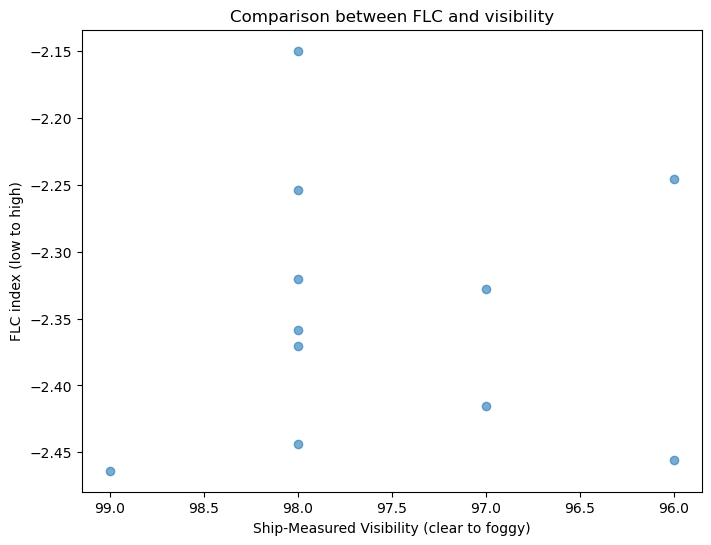

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(vis_values, flc_nearest_values, alpha=0.6)
plt.gca().invert_xaxis()
plt.xlabel('Ship-Measured Visibility (clear to foggy)')
plt.ylabel('FLC index (low to high)')
plt.title('Comparison between FLC and visibility')
plt.show()

In [11]:
np.shape(flc_nearest_values)

(11,)

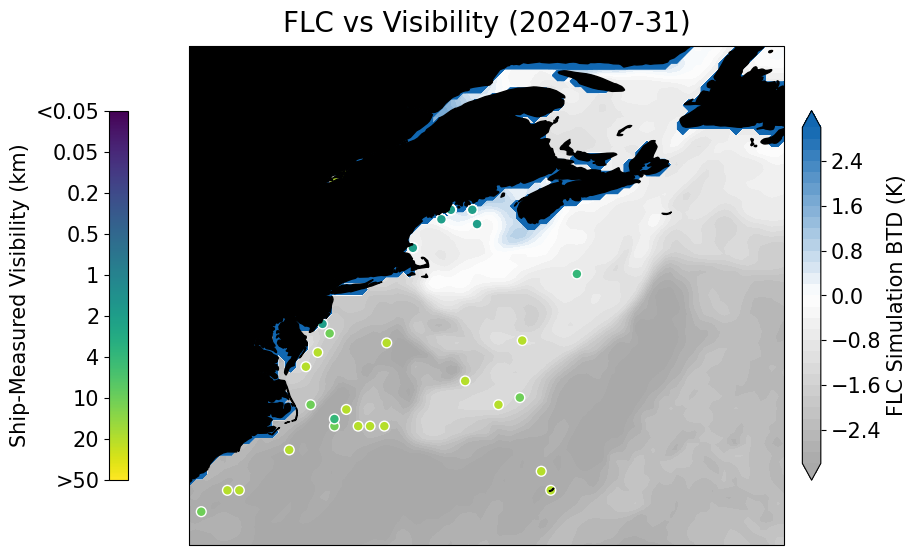

In [12]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import make_axes

# Define the projection and figure
projection = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(1, figsize=(12, 12), subplot_kw={'projection': projection})

# Custom colormap for contour plot
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
levels = np.linspace(-3, 3, 31)

# Contour plot
c = ax.contourf(flc_lon, flc_lat, flc_values, cmap=cmap, extend='both', levels=levels)

# Scatter plot
s = ax.scatter(filtered_non_null_ds.VV.lon, filtered_non_null_ds.VV.lat, c=filtered_non_null_ds.VV, edgecolors='white', s=50, cmap='viridis')

# Add primary colorbar for the contour plot
clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('FLC Simulation BTD (K)', fontsize=15)

# Add secondary colorbar for the scatter plot
cax_s, kw_s = make_axes(ax, shrink=0.4, pad=0.08, location='left')
clb_s = plt.colorbar(s, cax=cax_s, **kw_s)
clb_s.ax.invert_yaxis()
custom_ticks = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
custom_labels = ['<0.05', '0.05', '0.2', '0.5', '1', '2', '4', '10', '20', '>50']
clb_s.set_ticks(custom_ticks)
clb_s.set_ticklabels(custom_labels)
clb_s.ax.tick_params(labelsize=15)
clb_s.set_label('Ship-Measured Visibility (km)', fontsize=15)

# Set map extent
ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

# Title and land features
ax.set_title("FLC vs Visibility (" + date + ")", fontsize=20, pad=10)
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')

plt.show()


Checking to see if the colocation worked -- so far, looks like no

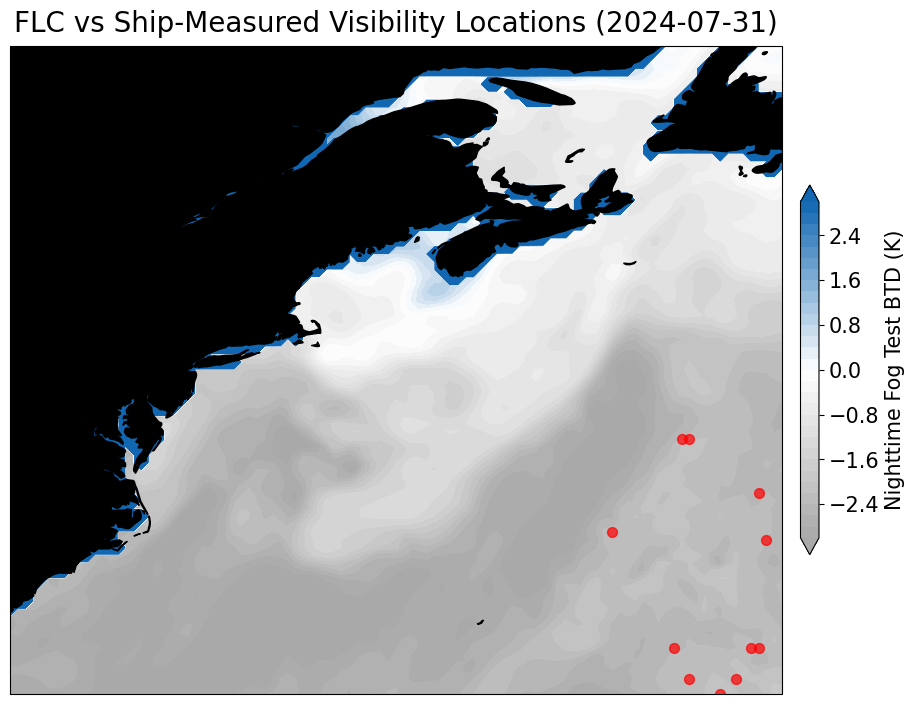

In [13]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

levels = np.linspace(-3, 3, 31)

#--- Original local mapping
c=ax.contourf(flc_lon, flc_lat, flc_values, cmap=cmap, extend='both', levels=levels)
s=ax.scatter(flc_nearest_lons+180, flc_nearest_lats, color='red', label='Nearest FLC Data', s=50, alpha=0.7)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('Nighttime Fog Test BTD (K)', fontsize=15)

#--- Remove for global mapping
ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("FLC vs Ship-Measured Visibility Locations ("+date+")", fontsize=20, pad=10)

#--- Land in black
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')